In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time 
import gpytorch
from gpytorch.functions import pivoted_cholesky

from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel
from gpytorch.priors import GammaPrior
from gpytorch.likelihoods import GaussianLikelihood
import torch
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
# Set device and global dtype
device = "cuda:0"
global_dtype = torch.float32

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Add project source path
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../code'))
if src_path not in sys.path:
    sys.path.append(src_path)

# Import custom modules
from gps import CholeskyGaussianProcess, IterativeGaussianProcess
from util import train, eval, plot_gpr_results, fetch_uci_dataset, memory_dump
from plotting import plot_gp_simple, plot_gp_sample, plot_gp_simple_regions

# Enable autoreloading of modules
%load_ext autoreload
%autoreload 2
train_x, train_y, test_x, test_y = fetch_uci_dataset('bike',r"C:\Users\fredw\chris\Research\softki\data\uci_datasets\uci_datasets\elevators\data.csv",train_frac=4/10,val_frac=0)
train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
print(train_x.shape)

c:\Users\fredw\chris\Research\RandomIterativeGP\randomGP2\code\mbcg.py:58: SyntaxWarning: invalid escape sequence '\['
  """


SIZE (16599, 19)
Dataset loaded
torch.Size([6639, 17])


In [2]:
import torch
import matplotlib.pyplot as plt
from line_profiler import LineProfiler
from preconditioners import build_cholesky,_pivoted_cholesky
from mbcg import initialize_cg,cond_fn

def train2(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):
    model.fit(train_x, train_y)
    model.fit(train_x, train_y)
    model.fit(train_x, train_y)
    model.fit(train_x, train_y)
    model.fit(train_x, train_y)

    # optimizer = torch.optim.Adam([
    #     {'params': model.kernel.parameters()}, 
    #     {'params': [model.noise.u]}  # Use raw_value instead of noise()
    # ], lr=lr)
    # runtime_log, mll_loss_log, test_rmse_log = [], [], []
    # for i in tqdm(range(training_iterations)):
    #     start_time = time.time()
    #     optimizer.zero_grad()
        
    #     model.fit(train_x, train_y)
    #     loss = model.compute_mll(train_y)
    #     loss.backward()
    #     optimizer.step()
    #     # scheduler.step()  # Update the learning rate

    #     # print(loss)
    #     mean,covar = model.predict(test_x)
    #     total_time = time.time() - start_time
    #     runtime_log.append(total_time)
    #     mll_loss_log.append(-loss.item())
        
    #     test_rmse = (torch.mean(torch.abs(mean.detach().cpu() - test_y))).item()
    #     test_rmse_log.append(test_rmse)
    #     if (i + 1) % 20 == 0:
    #         print(f'Iter {i+1}/{training_iterations}, Loss: {loss.item():.4f}')
    
    # return model, runtime_log, mll_loss_log, test_rmse_log, mean, covar


def run_igp_training():
    # Set up the base and scaled kernel for the IGP
    base_kernel_igp = MaternKernel(ard_num_dims=train_x.shape[-1], 
                                   lengthscale_prior=GammaPrior(-3.0, 3.0), 
                                   nu=1.5)
    kernel_igp = ScaleKernel(base_kernel_igp, outputscale_prior=GammaPrior(-3.0, 3)).to("cuda:0")
    
    # Initialize the Iterative Gaussian Process model with the desired parameters
    igp_model = IterativeGaussianProcess(
        kernel=kernel_igp, 
        noise=0.4, 
        dtype=global_dtype, 
        device=device,
        cg_tol=1e-3, 
        cg_max_iter=100, 
        warm_start=True, 
        num_probes=16,
        precon_type="identity", 
        trace_backend="Hutch",
        verbose=False, 
        track_iterations=True, 
        pred_lanczos_rank=train_x.shape[0],
        compute_covariance=False
    )
    
    training_iterations = 1
    lr = 0.01

    print("Training Iterative Gaussian Process (IGP)")
    # Train the IGP model and capture relevant outputs2
    results = train2(igp_model, train_x, train_y, test_x, test_y, training_iterations, lr)
    return results

# Set up the line profiler
lp = LineProfiler()
from mbcg import take_cg_step
# from preconditioners import _pivoted_cholesky
# Add the main training function and key IGP class methods you want to profile.
# Here we add the train function, and as an example, the forward method of IterativeGaussianProcess.
lp.add_function(train2)
lp.add_function(take_cg_step)
lp.add_function(build_cholesky)
lp.add_function(_pivoted_cholesky)
lp.add_function(cond_fn)
lp.add_function(initialize_cg
)
lp.add_function(IterativeGaussianProcess.forward)
lp.add_function(IterativeGaussianProcess.fit)
lp.add_function(IterativeGaussianProcess.get_preconditioner)

# If there are other important methods (for example, an 'optimize' method), add them similarly:
# lp.add_function(IterativeGaussianProcess.optimize)

# Wrap the IGP training run with the profiler and execute it.
lp_wrapper = lp(run_igp_training)
results = lp_wrapper()

# Print out the profiling statistics.
lp.print_stats()

Training Iterative Gaussian Process (IGP)
Timer unit: 1e-07 s

Total time: 0.421693 s
File: C:\Users\fredw\AppData\Local\Temp\ipykernel_32524\1113260723.py
Function: train2 at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def train2(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):
     8         1    2424333.0    2e+06     57.5      model.fit(train_x, train_y)
     9         1     702268.0 702268.0     16.7      model.fit(train_x, train_y)
    10         1     249719.0 249719.0      5.9      model.fit(train_x, train_y)
    11         1     356574.0 356574.0      8.5      model.fit(train_x, train_y)
    12         1     484041.0 484041.0     11.5      model.fit(train_x, train_y)
    13                                           
    14                                               # optimizer = torch.optim.Adam([
    15                                               #     {'params': model.k

tensor(13352.7461, device='cuda:0', grad_fn=<MulBackward0>)
tensor(13343.9219, device='cuda:0', grad_fn=<MulBackward0>)
tensor(13344.0635, device='cuda:0', grad_fn=<MulBackward0>)
tensor(13358.6230, device='cuda:0', grad_fn=<MulBackward0>)
tensor(13353.2637, device='cuda:0', grad_fn=<MulBackward0>)
=== AVERAGED PERFORMANCE METRICS OVER 5 RUNS (Baseline: Cholesky GP) ===
------------------------------------------------------------
Cholesky GP Fit Time         : 0.0906 sec  (Baseline)
Iterative GP Fit Time        : 0.0627 sec
Fit Time Difference          : 0.0280 sec  (+30.85%)
Speedup Factor               : 1.45×
------------------------------------------------------------
Cholesky GP Prediction Time  : 0.0086 sec  (Baseline)
Iterative GP Prediction Time : 0.0054 sec
Prediction Time Difference   : 0.0031 sec  (+36.47%)
Speedup Factor               : 1.57×
------------------------------------------------------------
Cholesky GP Total Time       : 0.0992 sec  (Baseline)
Iterative GP Total

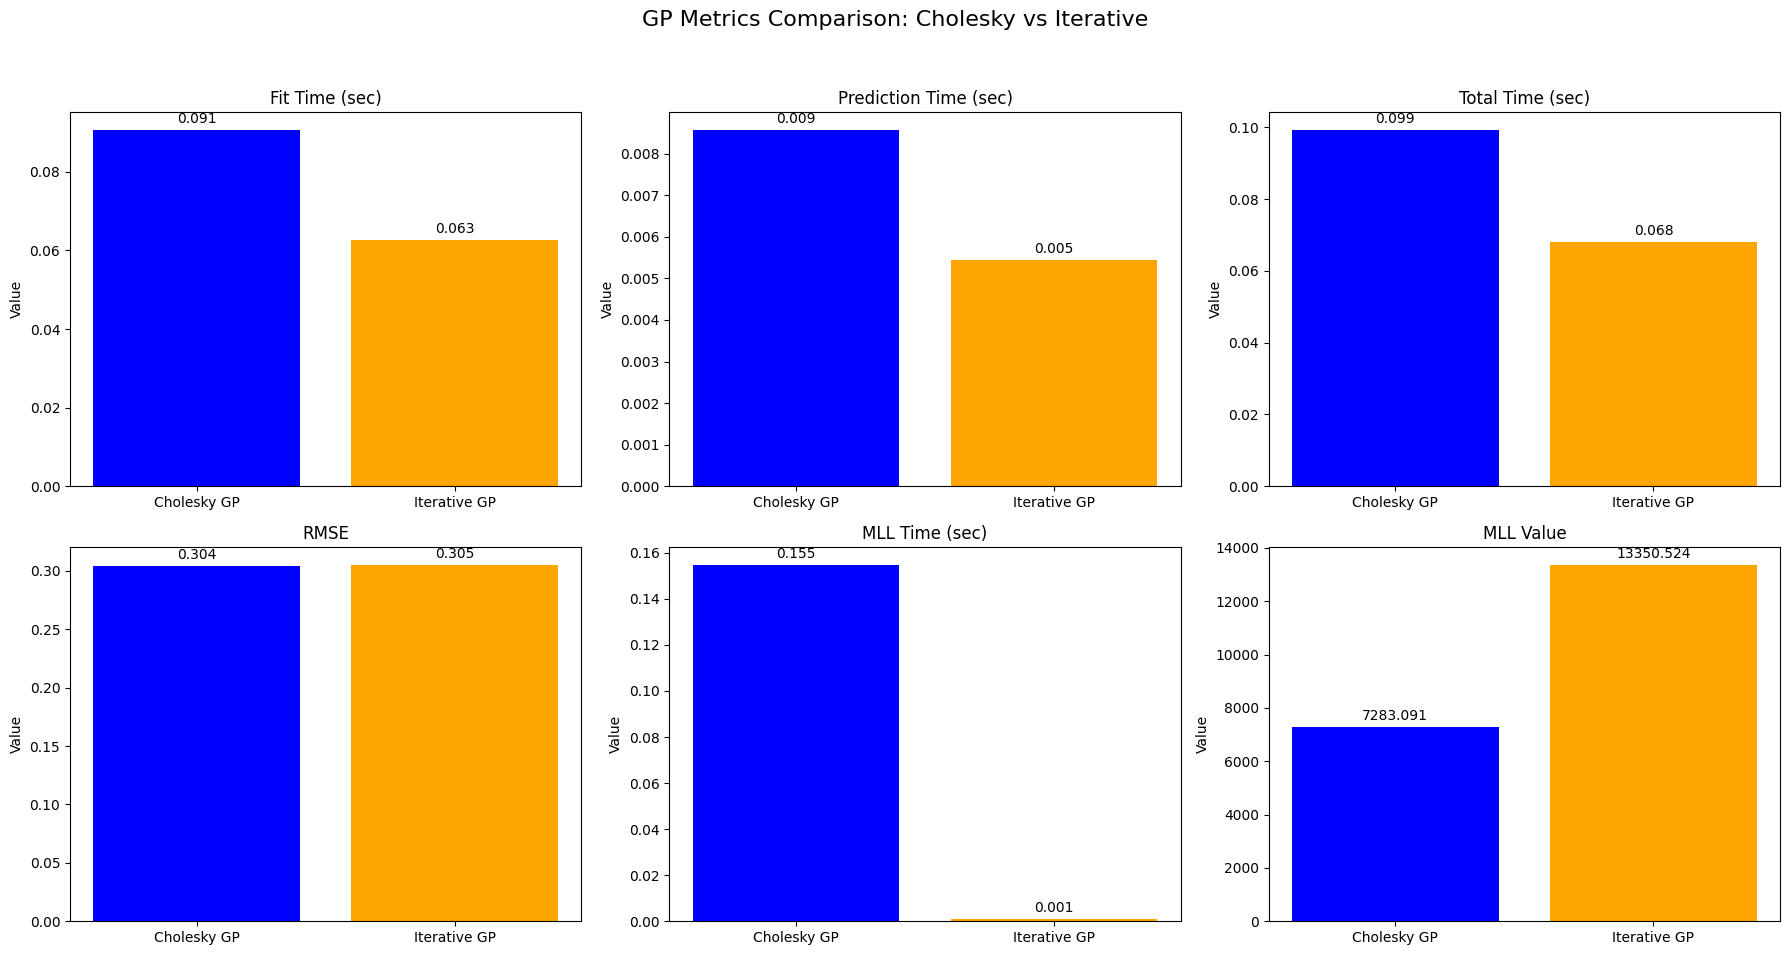

In [6]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming the following GP classes and kernels are defined elsewhere:
# MaternKernel, GammaPrior, ScaleKernel, CholeskyGaussianProcess, IterativeGaussianProcess

def run_cholesky_gp(train_x, train_y, test_x, test_y, device, global_dtype):
    base_kernel = MaternKernel(
        ard_num_dims=train_x.shape[-1],
        lengthscale_prior=GammaPrior(3.0, 6.0),
        nu=1.5,
        compute_covariance=False
    )
    kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)
    gpr = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=0.4, device=device)
    
    # Fit GP
    start_fit = time.time()
    gpr.fit(train_x, train_y)
    chol_fit_time = time.time() - start_fit

    # Prediction
    start_pred = time.time()
    chol_mean, GP_covariance = gpr.predict(test_x)
    chol_pred_time = time.time() - start_pred

    # MLL computation
    startmll = time.time()
    chol_mll_value = gpr.compute_mll(train_y)
    chol_mll_time = time.time() - startmll

    chol_total_time = chol_fit_time + chol_pred_time
    chol_rmse = torch.mean(torch.abs(chol_mean.detach().cpu() - test_y)).item()

    # Clean up intermediate objects to free memory between runs
    del gpr, kernel, base_kernel, chol_mean, GP_covariance
    torch.cuda.empty_cache()
    
    return chol_total_time, chol_fit_time, chol_pred_time, chol_rmse, chol_mll_time, chol_mll_value.detach().cpu()

def run_iterative_gp(train_x, train_y, test_x, test_y, device, global_dtype):
    base_kernel = MaternKernel(
        ard_num_dims=train_x.shape[-1],
        lengthscale_prior=GammaPrior(3.0, 6.0),
        nu=1.5
    )
    kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)
    
    igp = IterativeGaussianProcess(
        kernel=kernel,
        noise=0.4,
        dtype=global_dtype,
        device=device,
        cg_tol=1e-3,
        cg_max_iter=20,
        warm_start=False,
        num_probes=16,
        precon_type="piv_chol",
        trace_backend="Hutch",
        verbose=False,
        track_iterations=True,
        pred_lanczos_rank=train_x.shape[0],
        compute_covariance=False
    )
    
    # Fit GP
    start_fit = time.time()
    igp.fit(train_x, train_y)
    iter_fit_time = time.time() - start_fit

    # Prediction
    start_pred = time.time()
    mean, covar = igp.predict(test_x)
    iter_pred_time = time.time() - start_pred
    
    iter_total_time = iter_fit_time + iter_pred_time
    iter_rmse = torch.mean(torch.abs(mean.detach().cpu() - test_y)).item()

    # MLL computation
    startmll = time.time()
    iter_mll_value = igp.compute_mll(train_y)
    iter_mll_time = time.time() - startmll
    print(iter_mll_value)
    # Clean up intermediate objects to free memory between runs
    del igp, kernel, base_kernel, mean, covar
    torch.cuda.empty_cache()
    
    return iter_total_time, iter_fit_time, iter_pred_time, iter_rmse, iter_mll_time, iter_mll_value.detach().cpu()

# Number of runs to average over
num_runs = 5

chol_metrics = []
iter_metrics = []

for _ in range(num_runs):
    chol_metrics.append(run_cholesky_gp(train_x, train_y, test_x, test_y, device, global_dtype))
    iter_metrics.append(run_iterative_gp(train_x, train_y, test_x, test_y, device, global_dtype))
    # Delete any leftover variables between runs
    torch.cuda.empty_cache()

# Convert to numpy arrays for averaging
# Each metric: [total_time, fit_time, pred_time, rmse, mll_time, mll_value]
chol_metrics = np.array(chol_metrics)
iter_metrics = np.array(iter_metrics)

chol_total_avg, chol_fit_avg, chol_pred_avg, chol_rmse_avg, chol_mll_time_avg, chol_mll_value_avg = np.mean(chol_metrics, axis=0)
iter_total_avg, iter_fit_avg, iter_pred_avg, iter_rmse_avg, iter_mll_time_avg, iter_mll_value_avg = np.mean(iter_metrics, axis=0)

fit_speedup = ((chol_fit_avg - iter_fit_avg) / chol_fit_avg) * 100
pred_speedup = ((chol_pred_avg - iter_pred_avg) / chol_pred_avg) * 100
total_speedup = ((chol_total_avg - iter_total_avg) / chol_total_avg) * 100
mll_speedup = ((chol_mll_time_avg - iter_mll_time_avg) / chol_mll_time_avg) * 100

fit_factor = chol_fit_avg / iter_fit_avg if iter_fit_avg != 0 else float('inf')
pred_factor = chol_pred_avg / iter_pred_avg if iter_pred_avg != 0 else float('inf')
total_factor = chol_total_avg / iter_total_avg if iter_total_avg != 0 else float('inf')
mll_factor = chol_mll_time_avg / iter_mll_time_avg if iter_mll_time_avg != 0 else float('inf')

RED = "\033[91m"
GREEN = "\033[92m"
RESET = "\033[0m"

def format_speedup(speedup):
    sign = "+" if speedup >= 0 else "-"
    color = GREEN if speedup >= 0 else RED
    return f"{color}{sign}{abs(speedup):.2f}%{RESET}"

print("=== AVERAGED PERFORMANCE METRICS OVER 5 RUNS (Baseline: Cholesky GP) ===")
print("------------------------------------------------------------")
print(f"Cholesky GP Fit Time         : {chol_fit_avg:.4f} sec  (Baseline)")
print(f"Iterative GP Fit Time        : {iter_fit_avg:.4f} sec")
print(f"Fit Time Difference          : {chol_fit_avg - iter_fit_avg:.4f} sec  ({format_speedup(fit_speedup)})")
print(f"Speedup Factor               : {fit_factor:.2f}×")
print("------------------------------------------------------------")
print(f"Cholesky GP Prediction Time  : {chol_pred_avg:.4f} sec  (Baseline)")
print(f"Iterative GP Prediction Time : {iter_pred_avg:.4f} sec")
print(f"Prediction Time Difference   : {chol_pred_avg - iter_pred_avg:.4f} sec  ({format_speedup(pred_speedup)})")
print(f"Speedup Factor               : {pred_factor:.2f}×")
print("------------------------------------------------------------")
print(f"Cholesky GP Total Time       : {chol_total_avg:.4f} sec  (Baseline)")
print(f"Iterative GP Total Time      : {iter_total_avg:.4f} sec")
print(f"Total Time Difference        : {chol_total_avg - iter_total_avg:.4f} sec  ({format_speedup(total_speedup)})")
print(f"Speedup Factor               : {total_factor:.2f}×")
print("------------------------------------------------------------")
print(f"Cholesky GP MLL Computation  : {chol_mll_time_avg:.4f} sec  (Baseline)")
print(f"Iterative GP MLL Computation : {iter_mll_time_avg:.4f} sec")
print(f"MLL Time Difference          : {chol_mll_time_avg - iter_mll_time_avg:.4f} sec  ({format_speedup(mll_speedup)})")
print(f"Speedup Factor               : {mll_factor:.2f}×")
print("------------------------------------------------------------")
print("=== AVERAGED ACCURACY METRICS OVER 5 RUNS ===")
print(f"Cholesky GP RMSE             : {chol_rmse_avg:.4f}  (Baseline)")
print(f"Iterative GP RMSE            : {iter_rmse_avg:.4f}")
print(f"RMSE Difference              : {iter_rmse_avg - chol_rmse_avg:.4f}")
print("------------------------------------------------------------")
print("=== AVERAGED MLL VALUES OVER 5 RUNS ===")
print(f"Cholesky GP MLL Value        : {chol_mll_value_avg:.4f}  (Baseline)")
print(f"Iterative GP MLL Value       : {iter_mll_value_avg:.4f}")
print(f"MLL Value Difference         : {iter_mll_value_avg - chol_mll_value_avg:.4f}")
print("------------------------------------------------------------")

# Separate bar charts for each metric in a 2x3 grid
metric_labels = ['Fit Time (sec)', 'Prediction Time (sec)', 'Total Time (sec)', 'RMSE', 'MLL Time (sec)', 'MLL Value']
chol_vals = [chol_fit_avg, chol_pred_avg, chol_total_avg, chol_rmse_avg, chol_mll_time_avg, chol_mll_value_avg]
iter_vals = [iter_fit_avg, iter_pred_avg, iter_total_avg, iter_rmse_avg, iter_mll_time_avg, iter_mll_value_avg]

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, label in enumerate(metric_labels):
    ax = axs[i]
    categories = ['Cholesky GP', 'Iterative GP']
    values = [chol_vals[i], iter_vals[i]]
    bar_colors = ['blue', 'orange']
    
    bars = ax.bar(categories, values, color=bar_colors)
    ax.set_title(label)
    ax.set_ylabel("Value")
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
fig.suptitle("GP Metrics Comparison: Cholesky vs Iterative", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

  2%|▏         | 1/50 [00:00<00:20,  2.42it/s]

tensor(7277.5234, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7267.0259, device='cuda:0', grad_fn=<MulBackward0>)


  6%|▌         | 3/50 [00:00<00:09,  4.84it/s]

tensor(7251.7383, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7235.1230, device='cuda:0', grad_fn=<MulBackward0>)


 10%|█         | 5/50 [00:01<00:08,  5.60it/s]

tensor(7224.2881, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7206.8408, device='cuda:0', grad_fn=<MulBackward0>)


 14%|█▍        | 7/50 [00:01<00:07,  5.81it/s]

tensor(7204.0820, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7182.0410, device='cuda:0', grad_fn=<MulBackward0>)


 18%|█▊        | 9/50 [00:01<00:06,  6.15it/s]

tensor(7182.1738, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7171.8501, device='cuda:0', grad_fn=<MulBackward0>)


 22%|██▏       | 11/50 [00:01<00:06,  6.24it/s]

tensor(7160.6328, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7141.3838, device='cuda:0', grad_fn=<MulBackward0>)


 26%|██▌       | 13/50 [00:02<00:05,  6.47it/s]

tensor(7139.7148, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7129.5293, device='cuda:0', grad_fn=<MulBackward0>)


 30%|███       | 15/50 [00:02<00:05,  6.46it/s]

tensor(7125.0459, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7109.3809, device='cuda:0', grad_fn=<MulBackward0>)


 34%|███▍      | 17/50 [00:02<00:05,  6.44it/s]

tensor(7105.4517, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7092.3989, device='cuda:0', grad_fn=<MulBackward0>)


 38%|███▊      | 19/50 [00:03<00:04,  6.44it/s]

tensor(7082.6479, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7082.3350, device='cuda:0', grad_fn=<MulBackward0>)


 42%|████▏     | 21/50 [00:03<00:04,  6.37it/s]

Iter 20/50, Loss: 7082.3350
tensor(7090.8633, device='cuda:0', grad_fn=<MulBackward0>)


 44%|████▍     | 22/50 [00:03<00:04,  6.39it/s]

tensor(7075.6953, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7063.1709, device='cuda:0', grad_fn=<MulBackward0>)


 48%|████▊     | 24/50 [00:04<00:04,  6.26it/s]

tensor(7058.9380, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7053.3101, device='cuda:0', grad_fn=<MulBackward0>)


 52%|█████▏    | 26/50 [00:04<00:03,  6.37it/s]

tensor(7051.8525, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7052.8301, device='cuda:0', grad_fn=<MulBackward0>)


 56%|█████▌    | 28/50 [00:04<00:03,  6.46it/s]

tensor(7046.8115, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7037.4697, device='cuda:0', grad_fn=<MulBackward0>)


 60%|██████    | 30/50 [00:04<00:03,  6.38it/s]

tensor(7045.3345, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7041.4985, device='cuda:0', grad_fn=<MulBackward0>)


 64%|██████▍   | 32/50 [00:05<00:02,  6.54it/s]

tensor(7038.3970, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7038.3452, device='cuda:0', grad_fn=<MulBackward0>)


 68%|██████▊   | 34/50 [00:05<00:02,  6.21it/s]

tensor(7048.4004, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7037.5596, device='cuda:0', grad_fn=<MulBackward0>)


 72%|███████▏  | 36/50 [00:05<00:02,  6.15it/s]

tensor(7030.7705, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7039.5884, device='cuda:0', grad_fn=<MulBackward0>)


 76%|███████▌  | 38/50 [00:06<00:01,  6.00it/s]

tensor(7029.8984, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7039.0781, device='cuda:0', grad_fn=<MulBackward0>)


 80%|████████  | 40/50 [00:06<00:01,  6.04it/s]

tensor(7038.3647, device='cuda:0', grad_fn=<MulBackward0>)
Iter 40/50, Loss: 7038.3647
tensor(7027.7969, device='cuda:0', grad_fn=<MulBackward0>)


 84%|████████▍ | 42/50 [00:06<00:01,  5.88it/s]

tensor(7033.3838, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7039.6909, device='cuda:0', grad_fn=<MulBackward0>)


 88%|████████▊ | 44/50 [00:07<00:01,  5.85it/s]

tensor(7039.1421, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7040.2051, device='cuda:0', grad_fn=<MulBackward0>)


 92%|█████████▏| 46/50 [00:07<00:00,  6.14it/s]

tensor(7053.4971, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7036.5098, device='cuda:0', grad_fn=<MulBackward0>)


 96%|█████████▌| 48/50 [00:07<00:00,  5.85it/s]

tensor(7049.8164, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7050.3003, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


tensor(7051.0044, device='cuda:0', grad_fn=<MulBackward0>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(7283.0908, device='cuda:0', grad_fn=<MulBackward0>)


  2%|▏         | 1/50 [00:00<00:13,  3.52it/s]

tensor(7241.1377, device='cuda:0', grad_fn=<MulBackward0>)


  4%|▍         | 2/50 [00:00<00:13,  3.46it/s]

tensor(7198.8662, device='cuda:0', grad_fn=<MulBackward0>)


  6%|▌         | 3/50 [00:00<00:13,  3.46it/s]

tensor(7156.2661, device='cuda:0', grad_fn=<MulBackward0>)


  8%|▊         | 4/50 [00:01<00:13,  3.44it/s]

tensor(7113.3442, device='cuda:0', grad_fn=<MulBackward0>)


 10%|█         | 5/50 [00:01<00:13,  3.45it/s]

tensor(7070.1045, device='cuda:0', grad_fn=<MulBackward0>)


 12%|█▏        | 6/50 [00:01<00:12,  3.45it/s]

tensor(7026.5439, device='cuda:0', grad_fn=<MulBackward0>)


 14%|█▍        | 7/50 [00:02<00:12,  3.45it/s]

tensor(6982.6416, device='cuda:0', grad_fn=<MulBackward0>)


 16%|█▌        | 8/50 [00:02<00:12,  3.44it/s]

tensor(6938.4150, device='cuda:0', grad_fn=<MulBackward0>)


 18%|█▊        | 9/50 [00:02<00:11,  3.45it/s]

tensor(6893.9233, device='cuda:0', grad_fn=<MulBackward0>)


 20%|██        | 10/50 [00:02<00:11,  3.44it/s]

tensor(6848.9771, device='cuda:0', grad_fn=<MulBackward0>)


 22%|██▏       | 11/50 [00:03<00:11,  3.45it/s]

tensor(6803.7690, device='cuda:0', grad_fn=<MulBackward0>)


 24%|██▍       | 12/50 [00:03<00:11,  3.44it/s]

tensor(6758.2373, device='cuda:0', grad_fn=<MulBackward0>)


 26%|██▌       | 13/50 [00:03<00:10,  3.45it/s]

tensor(6712.3838, device='cuda:0', grad_fn=<MulBackward0>)


 28%|██▊       | 14/50 [00:04<00:10,  3.45it/s]

tensor(6666.1738, device='cuda:0', grad_fn=<MulBackward0>)


 30%|███       | 15/50 [00:04<00:10,  3.45it/s]

tensor(6619.6597, device='cuda:0', grad_fn=<MulBackward0>)


 32%|███▏      | 16/50 [00:04<00:09,  3.44it/s]

tensor(6572.8335, device='cuda:0', grad_fn=<MulBackward0>)


 34%|███▍      | 17/50 [00:04<00:09,  3.44it/s]

tensor(6525.6548, device='cuda:0', grad_fn=<MulBackward0>)


 36%|███▌      | 18/50 [00:05<00:09,  3.44it/s]

tensor(6478.1831, device='cuda:0', grad_fn=<MulBackward0>)


 38%|███▊      | 19/50 [00:05<00:09,  3.44it/s]

tensor(6430.4429, device='cuda:0', grad_fn=<MulBackward0>)


 40%|████      | 20/50 [00:05<00:08,  3.45it/s]

Iter 20/50, Loss: 6430.4429
tensor(6382.3496, device='cuda:0', grad_fn=<MulBackward0>)


 42%|████▏     | 21/50 [00:06<00:08,  3.45it/s]

tensor(6333.8428, device='cuda:0', grad_fn=<MulBackward0>)


 44%|████▍     | 22/50 [00:06<00:08,  3.44it/s]

tensor(6285.1626, device='cuda:0', grad_fn=<MulBackward0>)


 46%|████▌     | 23/50 [00:06<00:07,  3.45it/s]

tensor(6236.0410, device='cuda:0', grad_fn=<MulBackward0>)


 48%|████▊     | 24/50 [00:06<00:07,  3.49it/s]

tensor(6186.6851, device='cuda:0', grad_fn=<MulBackward0>)


 50%|█████     | 25/50 [00:07<00:07,  3.43it/s]

tensor(6137.1187, device='cuda:0', grad_fn=<MulBackward0>)


 52%|█████▏    | 26/50 [00:07<00:06,  3.43it/s]

tensor(6087.1045, device='cuda:0', grad_fn=<MulBackward0>)


 54%|█████▍    | 27/50 [00:07<00:06,  3.43it/s]

tensor(6036.8555, device='cuda:0', grad_fn=<MulBackward0>)


 56%|█████▌    | 28/50 [00:08<00:06,  3.43it/s]

tensor(5986.4277, device='cuda:0', grad_fn=<MulBackward0>)


 58%|█████▊    | 29/50 [00:08<00:06,  3.43it/s]

tensor(5935.5854, device='cuda:0', grad_fn=<MulBackward0>)


 60%|██████    | 30/50 [00:08<00:05,  3.44it/s]

tensor(5884.4092, device='cuda:0', grad_fn=<MulBackward0>)


 62%|██████▏   | 31/50 [00:08<00:05,  3.44it/s]

tensor(5833.0391, device='cuda:0', grad_fn=<MulBackward0>)


 64%|██████▍   | 32/50 [00:09<00:05,  3.44it/s]

tensor(5781.4014, device='cuda:0', grad_fn=<MulBackward0>)


 66%|██████▌   | 33/50 [00:09<00:04,  3.44it/s]

tensor(5729.4922, device='cuda:0', grad_fn=<MulBackward0>)


 68%|██████▊   | 34/50 [00:09<00:04,  3.43it/s]

tensor(5677.3237, device='cuda:0', grad_fn=<MulBackward0>)


 70%|███████   | 35/50 [00:10<00:04,  3.43it/s]

tensor(5624.8960, device='cuda:0', grad_fn=<MulBackward0>)


 72%|███████▏  | 36/50 [00:10<00:04,  3.43it/s]

tensor(5572.2148, device='cuda:0', grad_fn=<MulBackward0>)


 74%|███████▍  | 37/50 [00:10<00:03,  3.43it/s]

tensor(5519.3062, device='cuda:0', grad_fn=<MulBackward0>)


 76%|███████▌  | 38/50 [00:11<00:03,  3.43it/s]

tensor(5466.1406, device='cuda:0', grad_fn=<MulBackward0>)


 78%|███████▊  | 39/50 [00:11<00:03,  3.43it/s]

tensor(5412.8135, device='cuda:0', grad_fn=<MulBackward0>)


 80%|████████  | 40/50 [00:11<00:02,  3.43it/s]

Iter 40/50, Loss: 5412.8135
tensor(5359.1797, device='cuda:0', grad_fn=<MulBackward0>)


 82%|████████▏ | 41/50 [00:11<00:02,  3.42it/s]

tensor(5305.2236, device='cuda:0', grad_fn=<MulBackward0>)


 84%|████████▍ | 42/50 [00:12<00:02,  3.42it/s]

tensor(5251.1460, device='cuda:0', grad_fn=<MulBackward0>)


 86%|████████▌ | 43/50 [00:12<00:02,  3.42it/s]

tensor(5196.8413, device='cuda:0', grad_fn=<MulBackward0>)


 88%|████████▊ | 44/50 [00:12<00:01,  3.42it/s]

tensor(5142.3452, device='cuda:0', grad_fn=<MulBackward0>)


 90%|█████████ | 45/50 [00:13<00:01,  3.43it/s]

tensor(5087.6162, device='cuda:0', grad_fn=<MulBackward0>)


 92%|█████████▏| 46/50 [00:13<00:01,  3.42it/s]

tensor(5032.6997, device='cuda:0', grad_fn=<MulBackward0>)


 94%|█████████▍| 47/50 [00:13<00:00,  3.42it/s]

tensor(4977.5830, device='cuda:0', grad_fn=<MulBackward0>)


 96%|█████████▌| 48/50 [00:13<00:00,  3.42it/s]

tensor(4922.3926, device='cuda:0', grad_fn=<MulBackward0>)


 98%|█████████▊| 49/50 [00:14<00:00,  3.42it/s]

tensor(4866.8970, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:14<00:00,  3.44it/s]


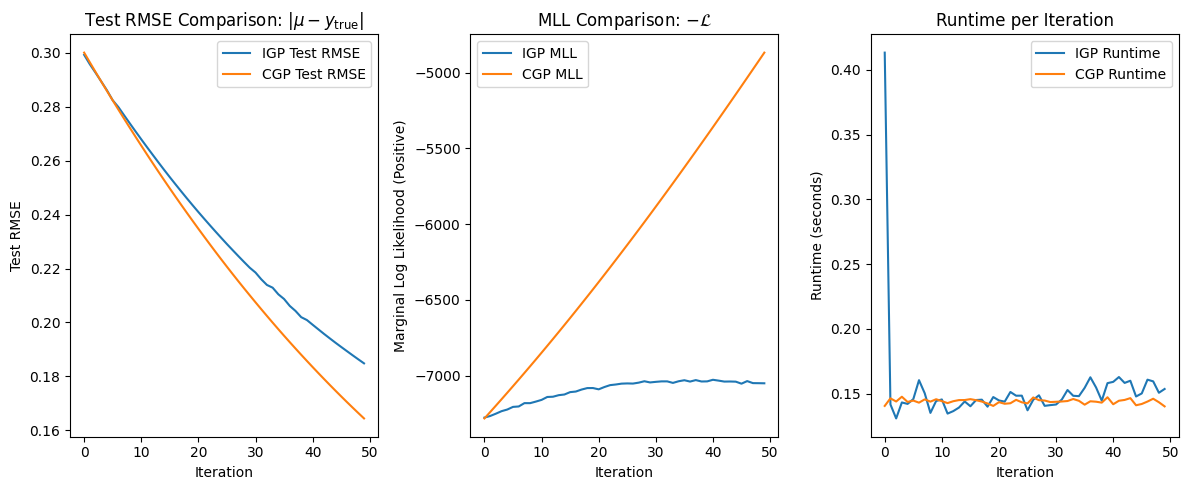

In [8]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):
    optimizer = torch.optim.Adam([
        {'params': model.kernel.parameters()}, 
        {'params': [model.noise.u]}  # Use raw_value instead of noise()
    ], lr=lr)
    
    runtime_log, mll_loss_log, test_rmse_log = [], [], []
    
    for i in tqdm(range(training_iterations)):
        start_time = time.time()
        
        optimizer.zero_grad()
        model.fit(train_x, train_y)
        loss = model.compute_mll(train_y)
        print(loss)
        loss.backward()
        optimizer.step()
        
        mean, covar = model.predict(test_x)
        
        total_time = time.time() - start_time
        runtime_log.append(total_time)
        mll_loss_log.append(-loss.item())  # Logging positive MLL value
        
        test_rmse = torch.mean(torch.abs(mean.detach().cpu()- test_y)).item()
        test_rmse_log.append(test_rmse)
        
        if (i + 1) % 20 == 0:
            print(f'Iter {i+1}/{training_iterations}, Loss: {loss.item():.4f}')
    
    return model, runtime_log, mll_loss_log, test_rmse_log, mean, covar

# Example usage:
# Assuming that model_igp and model_cgp are instantiated GP models (Iterative GP and Cholesky GP respectively),
# and train_x, train_y, test_x, test_y are already defined.
base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1], lengthscale_prior=GammaPrior(3.0, 6.0), nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

cgp = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=0.4, device=device)


base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1], lengthscale_prior=GammaPrior(3.0, 6.0), nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

igp = IterativeGaussianProcess(kernel=kernel, noise=0.4, dtype=global_dtype, device=device,
                               cg_tol=1e-2, cg_max_iter=100, warm_start=True, num_probes=16,
                               precon_type="identity", trace_backend="Hutch",
                               verbose=False, track_iterations=False, 
                               pred_lanczos_rank=train_x.shape[0], compute_covariance=False)
                               
# Train the iterative GP model
model_igp, runtime_log_igp, mll_loss_log_igp, test_rmse_log_igp, mean_igp, covar_igp = train(igp, train_x, train_y, test_x, test_y, training_iterations=50, lr=0.01)

# Train the Cholesky-based GP model
model_cgp, runtime_log_cgp, mll_loss_log_cgp, test_rmse_log_cgp, mean_cgp, covar_cgp = train(cgp, train_x, train_y, test_x, test_y, training_iterations=50, lr=0.01)

# ----------------------------
# Two-Panel Plot: RMSE, MLL, and Runtime
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot RMSE comparison: |μ - yₜᵣᵤₑ|
axes[0].plot(test_rmse_log_igp, label="IGP Test RMSE")
axes[0].plot(test_rmse_log_cgp, label="CGP Test RMSE")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Test RMSE")
axes[0].set_title(r"Test RMSE Comparison: $|\mu - y_{\text{true}}|$")
axes[0].legend()

# Plot MLL comparison: -𝓛 (where a lower negative loss indicates a higher likelihood)
axes[1].plot(mll_loss_log_igp, label="IGP MLL")
axes[1].plot(mll_loss_log_cgp, label="CGP MLL")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Marginal Log Likelihood (Positive)")
axes[1].set_title(r"MLL Comparison: $-\mathcal{L}$")
axes[1].legend()

# Plot runtime per iteration
axes[2].plot(runtime_log_igp, label="IGP Runtime")
axes[2].plot(runtime_log_cgp, label="CGP Runtime")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Runtime (seconds)")
axes[2].set_title(r"Runtime per Iteration")
axes[2].legend()

plt.tight_layout()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\fredw\chris\Research\RandomIterativeGP\randomGP2\code\gps.py:336: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  quadratic = y.T @ self.alpha


tensor(7275.2563, device='cuda:0', grad_fn=<MulBackward0>)


  4%|▍         | 2/50 [00:00<00:15,  3.12it/s]

tensor(7266.4336, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7241.1074, device='cuda:0', grad_fn=<MulBackward0>)


  8%|▊         | 4/50 [00:01<00:09,  4.73it/s]

tensor(7239.3584, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7221.5938, device='cuda:0', grad_fn=<MulBackward0>)


 12%|█▏        | 6/50 [00:01<00:07,  5.68it/s]

tensor(7208.7485, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7203.1797, device='cuda:0', grad_fn=<MulBackward0>)


 16%|█▌        | 8/50 [00:01<00:06,  6.06it/s]

tensor(7176.4648, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7180.7500, device='cuda:0', grad_fn=<MulBackward0>)


 20%|██        | 10/50 [00:01<00:06,  6.18it/s]

tensor(7168.6738, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7153.7002, device='cuda:0', grad_fn=<MulBackward0>)


 24%|██▍       | 12/50 [00:02<00:05,  6.42it/s]

tensor(7151.2666, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7132.6475, device='cuda:0', grad_fn=<MulBackward0>)


 28%|██▊       | 14/50 [00:02<00:05,  6.33it/s]

tensor(7136.7568, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7120.7246, device='cuda:0', grad_fn=<MulBackward0>)


 32%|███▏      | 16/50 [00:02<00:05,  6.31it/s]

tensor(7120.3936, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7105.1138, device='cuda:0', grad_fn=<MulBackward0>)


 36%|███▌      | 18/50 [00:03<00:05,  6.27it/s]

tensor(7103.7632, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7097.3960, device='cuda:0', grad_fn=<MulBackward0>)


 40%|████      | 20/50 [00:03<00:04,  6.27it/s]

tensor(7079.0005, device='cuda:0', grad_fn=<MulBackward0>)
Iter 20/50, Loss: 7079.0005
tensor(7077.1875, device='cuda:0', grad_fn=<MulBackward0>)


 44%|████▍     | 22/50 [00:03<00:04,  6.33it/s]

tensor(7069.9292, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7064.2393, device='cuda:0', grad_fn=<MulBackward0>)


 48%|████▊     | 24/50 [00:04<00:04,  6.32it/s]

tensor(7061.6211, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7060.0488, device='cuda:0', grad_fn=<MulBackward0>)


 52%|█████▏    | 26/50 [00:04<00:03,  6.27it/s]

tensor(7053.7222, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7044.3237, device='cuda:0', grad_fn=<MulBackward0>)


 56%|█████▌    | 28/50 [00:04<00:03,  6.22it/s]

tensor(7046.6938, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7039.0713, device='cuda:0', grad_fn=<MulBackward0>)


 60%|██████    | 30/50 [00:05<00:03,  6.13it/s]

tensor(7039.1016, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7033.5059, device='cuda:0', grad_fn=<MulBackward0>)


 64%|██████▍   | 32/50 [00:05<00:02,  6.20it/s]

tensor(7035.1782, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7037.3545, device='cuda:0', grad_fn=<MulBackward0>)


 68%|██████▊   | 34/50 [00:05<00:02,  6.30it/s]

tensor(7027.9097, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7036.5151, device='cuda:0', grad_fn=<MulBackward0>)


 72%|███████▏  | 36/50 [00:06<00:02,  6.26it/s]

tensor(7035.5962, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7041.2720, device='cuda:0', grad_fn=<MulBackward0>)


 76%|███████▌  | 38/50 [00:06<00:01,  6.15it/s]

tensor(7028.8770, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7044.4336, device='cuda:0', grad_fn=<MulBackward0>)


 80%|████████  | 40/50 [00:06<00:01,  6.01it/s]

tensor(7046.0264, device='cuda:0', grad_fn=<MulBackward0>)
Iter 40/50, Loss: 7046.0264
tensor(7037.2100, device='cuda:0', grad_fn=<MulBackward0>)


 84%|████████▍ | 42/50 [00:07<00:01,  5.79it/s]

tensor(7040.6807, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7048.5420, device='cuda:0', grad_fn=<MulBackward0>)


 88%|████████▊ | 44/50 [00:07<00:01,  5.80it/s]

tensor(7049.3389, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7052.3369, device='cuda:0', grad_fn=<MulBackward0>)


 92%|█████████▏| 46/50 [00:07<00:00,  5.82it/s]

tensor(7048.0186, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7039.3213, device='cuda:0', grad_fn=<MulBackward0>)


 96%|█████████▌| 48/50 [00:08<00:00,  6.06it/s]

tensor(7050.5830, device='cuda:0', grad_fn=<MulBackward0>)
tensor(7057.4907, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


tensor(7045.1689, device='cuda:0', grad_fn=<MulBackward0>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(7283.0908, device='cuda:0', grad_fn=<MulBackward0>)


  2%|▏         | 1/50 [00:00<00:14,  3.45it/s]

tensor(7241.1377, device='cuda:0', grad_fn=<MulBackward0>)


  4%|▍         | 2/50 [00:00<00:14,  3.41it/s]

tensor(7198.8662, device='cuda:0', grad_fn=<MulBackward0>)


  6%|▌         | 3/50 [00:00<00:13,  3.42it/s]

tensor(7156.2661, device='cuda:0', grad_fn=<MulBackward0>)


  8%|▊         | 4/50 [00:01<00:13,  3.42it/s]

tensor(7113.3442, device='cuda:0', grad_fn=<MulBackward0>)


 10%|█         | 5/50 [00:01<00:13,  3.42it/s]

tensor(7070.1045, device='cuda:0', grad_fn=<MulBackward0>)


 12%|█▏        | 6/50 [00:01<00:12,  3.42it/s]

tensor(7026.5439, device='cuda:0', grad_fn=<MulBackward0>)


 14%|█▍        | 7/50 [00:02<00:12,  3.41it/s]

tensor(6982.6416, device='cuda:0', grad_fn=<MulBackward0>)


 16%|█▌        | 8/50 [00:02<00:12,  3.42it/s]

tensor(6938.4150, device='cuda:0', grad_fn=<MulBackward0>)


 18%|█▊        | 9/50 [00:02<00:12,  3.41it/s]

tensor(6893.9233, device='cuda:0', grad_fn=<MulBackward0>)


 20%|██        | 10/50 [00:02<00:11,  3.42it/s]

tensor(6848.9771, device='cuda:0', grad_fn=<MulBackward0>)


 22%|██▏       | 11/50 [00:03<00:11,  3.42it/s]

tensor(6803.7690, device='cuda:0', grad_fn=<MulBackward0>)


 24%|██▍       | 12/50 [00:03<00:11,  3.42it/s]

tensor(6758.2373, device='cuda:0', grad_fn=<MulBackward0>)


 26%|██▌       | 13/50 [00:03<00:10,  3.42it/s]

tensor(6712.3838, device='cuda:0', grad_fn=<MulBackward0>)


 28%|██▊       | 14/50 [00:04<00:10,  3.42it/s]

tensor(6666.1738, device='cuda:0', grad_fn=<MulBackward0>)


 30%|███       | 15/50 [00:04<00:10,  3.42it/s]

tensor(6619.6597, device='cuda:0', grad_fn=<MulBackward0>)


 32%|███▏      | 16/50 [00:04<00:09,  3.42it/s]

tensor(6572.8335, device='cuda:0', grad_fn=<MulBackward0>)


 34%|███▍      | 17/50 [00:04<00:09,  3.42it/s]

tensor(6525.6548, device='cuda:0', grad_fn=<MulBackward0>)


 36%|███▌      | 18/50 [00:05<00:09,  3.46it/s]

tensor(6478.1831, device='cuda:0', grad_fn=<MulBackward0>)


 38%|███▊      | 19/50 [00:05<00:09,  3.41it/s]

tensor(6430.4429, device='cuda:0', grad_fn=<MulBackward0>)


 40%|████      | 20/50 [00:05<00:08,  3.41it/s]

Iter 20/50, Loss: 6430.4429
tensor(6382.3496, device='cuda:0', grad_fn=<MulBackward0>)


 42%|████▏     | 21/50 [00:06<00:08,  3.42it/s]

tensor(6333.8428, device='cuda:0', grad_fn=<MulBackward0>)


 44%|████▍     | 22/50 [00:06<00:08,  3.41it/s]

tensor(6285.1626, device='cuda:0', grad_fn=<MulBackward0>)


 46%|████▌     | 23/50 [00:06<00:07,  3.41it/s]

tensor(6236.0410, device='cuda:0', grad_fn=<MulBackward0>)


 48%|████▊     | 24/50 [00:07<00:07,  3.41it/s]

tensor(6186.6851, device='cuda:0', grad_fn=<MulBackward0>)


 50%|█████     | 25/50 [00:07<00:07,  3.41it/s]

tensor(6137.1187, device='cuda:0', grad_fn=<MulBackward0>)


 52%|█████▏    | 26/50 [00:07<00:07,  3.41it/s]

tensor(6087.1045, device='cuda:0', grad_fn=<MulBackward0>)


 54%|█████▍    | 27/50 [00:07<00:06,  3.41it/s]

tensor(6036.8555, device='cuda:0', grad_fn=<MulBackward0>)


 56%|█████▌    | 28/50 [00:08<00:06,  3.40it/s]

tensor(5986.4277, device='cuda:0', grad_fn=<MulBackward0>)


 58%|█████▊    | 29/50 [00:08<00:06,  3.40it/s]

tensor(5935.5854, device='cuda:0', grad_fn=<MulBackward0>)


 60%|██████    | 30/50 [00:08<00:05,  3.41it/s]

tensor(5884.4092, device='cuda:0', grad_fn=<MulBackward0>)


 62%|██████▏   | 31/50 [00:09<00:05,  3.40it/s]

tensor(5833.0391, device='cuda:0', grad_fn=<MulBackward0>)


 64%|██████▍   | 32/50 [00:09<00:05,  3.40it/s]

tensor(5781.4014, device='cuda:0', grad_fn=<MulBackward0>)


 66%|██████▌   | 33/50 [00:09<00:05,  3.39it/s]

tensor(5729.4922, device='cuda:0', grad_fn=<MulBackward0>)


 68%|██████▊   | 34/50 [00:09<00:04,  3.41it/s]

tensor(5677.3237, device='cuda:0', grad_fn=<MulBackward0>)


 70%|███████   | 35/50 [00:10<00:04,  3.41it/s]

tensor(5624.8960, device='cuda:0', grad_fn=<MulBackward0>)


 72%|███████▏  | 36/50 [00:10<00:04,  3.40it/s]

tensor(5572.2148, device='cuda:0', grad_fn=<MulBackward0>)


 74%|███████▍  | 37/50 [00:10<00:03,  3.41it/s]

tensor(5519.3062, device='cuda:0', grad_fn=<MulBackward0>)


 76%|███████▌  | 38/50 [00:11<00:03,  3.41it/s]

tensor(5466.1406, device='cuda:0', grad_fn=<MulBackward0>)


 78%|███████▊  | 39/50 [00:11<00:03,  3.41it/s]

tensor(5412.8135, device='cuda:0', grad_fn=<MulBackward0>)


 80%|████████  | 40/50 [00:11<00:02,  3.42it/s]

Iter 40/50, Loss: 5412.8135
tensor(5359.1797, device='cuda:0', grad_fn=<MulBackward0>)


 82%|████████▏ | 41/50 [00:12<00:02,  3.42it/s]

tensor(5305.2236, device='cuda:0', grad_fn=<MulBackward0>)


 84%|████████▍ | 42/50 [00:12<00:02,  3.42it/s]

tensor(5251.1460, device='cuda:0', grad_fn=<MulBackward0>)


 86%|████████▌ | 43/50 [00:12<00:02,  3.42it/s]

tensor(5196.8413, device='cuda:0', grad_fn=<MulBackward0>)


 88%|████████▊ | 44/50 [00:12<00:01,  3.41it/s]

tensor(5142.3452, device='cuda:0', grad_fn=<MulBackward0>)


 90%|█████████ | 45/50 [00:13<00:01,  3.42it/s]

tensor(5087.6162, device='cuda:0', grad_fn=<MulBackward0>)


 92%|█████████▏| 46/50 [00:13<00:01,  3.41it/s]

tensor(5032.6997, device='cuda:0', grad_fn=<MulBackward0>)


 94%|█████████▍| 47/50 [00:13<00:00,  3.41it/s]

tensor(4977.5830, device='cuda:0', grad_fn=<MulBackward0>)


 96%|█████████▌| 48/50 [00:14<00:00,  3.41it/s]

tensor(4922.3926, device='cuda:0', grad_fn=<MulBackward0>)


 98%|█████████▊| 49/50 [00:14<00:00,  3.41it/s]

tensor(4866.8970, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


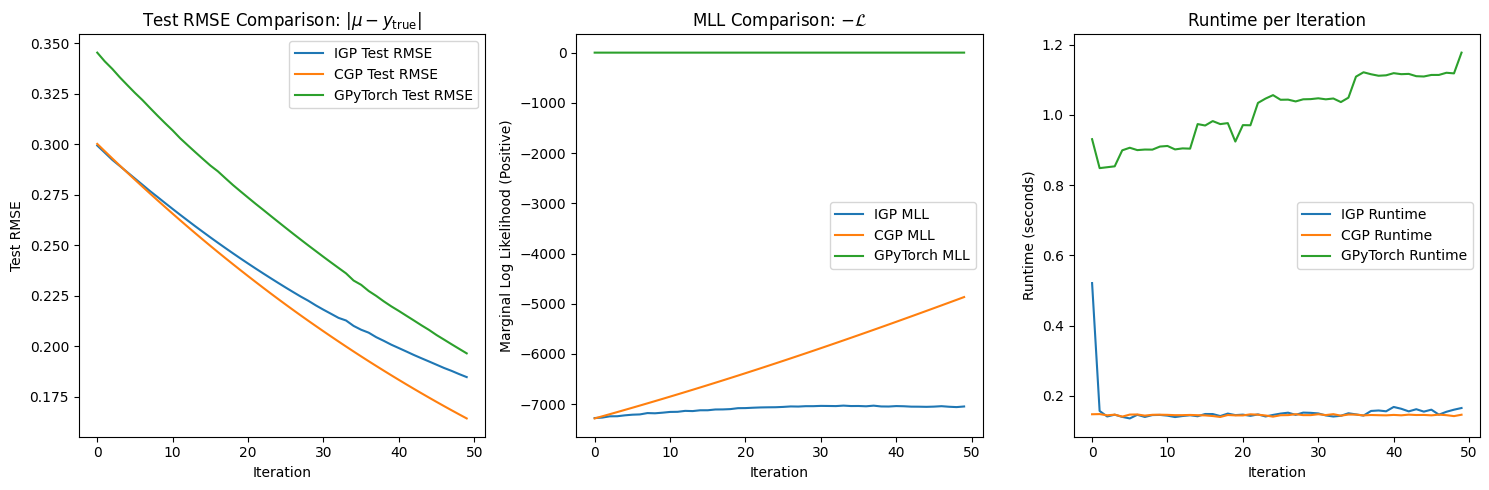

In [2]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import gpytorch

# Assume device is defined, e.g., device = torch.device("cuda:0")
# Move your datasets to the specified device
train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

# --- Define the training function for IGP and CGP (unchanged) ---
def train(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):
    optimizer = torch.optim.Adam([
        {'params': model.kernel.parameters()}, 
        {'params': [model.noise.u]}  # Use raw_value instead of noise()
    ], lr=lr)
    
    runtime_log, mll_loss_log, test_rmse_log = [], [], []
    
    for i in tqdm(range(training_iterations)):
        start_time = time.time()
        
        optimizer.zero_grad()
        model.fit(train_x, train_y)
        loss = model.compute_mll(train_y)
        print(loss)
        loss.backward()
        optimizer.step()
        
        mean, covar = model.predict(test_x)
        
        total_time = time.time() - start_time
        runtime_log.append(total_time)
        mll_loss_log.append(-loss.item())  # Logging positive MLL value
        
        test_rmse = torch.mean(torch.abs(mean - test_y)).item()
        test_rmse_log.append(test_rmse)
        
        if (i + 1) % 20 == 0:
            print(f'Iter {i+1}/{training_iterations}, Loss: {loss.item():.4f}')
    
    return model, runtime_log, mll_loss_log, test_rmse_log, mean, covar

# --- Define the GPyTorch exact GP regression model ---
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Constant mean and a Matern kernel (with $\nu=1.5$) scaled by a learned outputscale
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# --- Instantiate IGP and CGP models (using your provided setup) ---
base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1], lengthscale_prior=GammaPrior(3.0, 6.0), nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

cgp = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=0.4, device=device)

base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1], lengthscale_prior=GammaPrior(3.0, 6.0), nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

igp = IterativeGaussianProcess(kernel=kernel, noise=0.4, dtype=global_dtype, device=device,
                               cg_tol=1e-2, cg_max_iter=100, warm_start=True, num_probes=16,
                               precon_type="identity", trace_backend="Hutch",
                               verbose=False, track_iterations=False, 
                               pred_lanczos_rank=train_x.shape[0], compute_covariance=False)

# Train the iterative GP model
model_igp, runtime_log_igp, mll_loss_log_igp, test_rmse_log_igp, mean_igp, covar_igp = train(
    igp, train_x, train_y, test_x, test_y, training_iterations=50, lr=0.01)

# Train the Cholesky-based GP model
model_cgp, runtime_log_cgp, mll_loss_log_cgp, test_rmse_log_cgp, mean_cgp, covar_cgp = train(
    cgp, train_x, train_y, test_x, test_y, training_iterations=50, lr=0.01)

# --- Define and train the GPyTorch exact GP model ---
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model_gp = ExactGPModel(train_x, train_y, likelihood).to(device)

model_gp.train()
likelihood.train()
optimizer_gp = torch.optim.Adam(model_gp.parameters(), lr=0.01)
mll_gp = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_gp)

# Initialize logs for GPyTorch
runtime_log_gp, mll_loss_log_gp, test_rmse_log_gp = [], [], []
training_iterations = 50  # Using the same number of iterations

for i in tqdm(range(training_iterations)):
    start_time = time.time()
    optimizer_gp.zero_grad()
    output = model_gp(train_x)
    loss = -mll_gp(output, train_y)  # negative MLL to minimize
    loss.backward()
    optimizer_gp.step()
    
    # Switch to evaluation mode for prediction
    model_gp.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = likelihood(model_gp(test_x))
        mean_gp = preds.mean
        test_rmse_gp = torch.mean(torch.abs(mean_gp - test_y)).item()
    
    runtime_log_gp.append(time.time() - start_time)
    mll_loss_log_gp.append(-loss.item())  # Log positive MLL
    test_rmse_log_gp.append(test_rmse_gp)
    
    model_gp.train()
    likelihood.train()

# --- Plotting all three models ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE Comparison: $|\mu - y_{\text{true}}|$
axes[0].plot(test_rmse_log_igp, label="IGP Test RMSE")
axes[0].plot(test_rmse_log_cgp, label="CGP Test RMSE")
axes[0].plot(test_rmse_log_gp, label="GPyTorch Test RMSE")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Test RMSE")
axes[0].set_title(r"Test RMSE Comparison: $|\mu - y_{\text{true}}|$")
axes[0].legend()

# MLL Comparison: $-\mathcal{L}$ (a higher value implies a better likelihood)
axes[1].plot(mll_loss_log_igp, label="IGP MLL")
axes[1].plot(mll_loss_log_cgp, label="CGP MLL")
axes[1].plot(mll_loss_log_gp, label="GPyTorch MLL")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Marginal Log Likelihood (Positive)")
axes[1].set_title(r"MLL Comparison: $-\mathcal{L}$")
axes[1].legend()

# Runtime per Iteration
axes[2].plot(runtime_log_igp, label="IGP Runtime")
axes[2].plot(runtime_log_cgp, label="CGP Runtime")
axes[2].plot(runtime_log_gp, label="GPyTorch Runtime")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Runtime (seconds)")
axes[2].set_title(r"Runtime per Iteration")
axes[2].legend()

plt.tight_layout()
plt.show()

### Ideas: plot values of mll quantity,
Also add lanczos to the cholesky  :<